PHYS 349 Final Project: Numerical Simulation of Gravitational Lensing
==============
### Authors: Yu Li, Zhiyao Wang, Shen Zuo

### Declaration of Contributions
All members have worked jointly towards the completion of this final project. In particular, we worked together on the original version of the code (which is the code that we will show in the comparison section below). After professor Mike Hudson enlightened us on how to resolve the efficiency issue of that code, Zhiyao Wang mainly worked on developing the new efficient version of the code (which we will show in the implementation section below). Shen Zuo and Yu Li then debugged the code and developed various testing cases to examine the efficiecy and accuracy of this code. Shen Zuo also developed many testing cases in the exploration section. Yu Li then edited these cases to make them more concrete and organized. Yu Li was also mainly in charge of the writing of this report. He edited the language, equations and citations to make this report more academically rigorous. 

## Introduction and Motivation

Gravitational lensing is a magical and beautiful phenomenon occurring in the deep, mysterious universe. It directly testifies the predictions of Einstein's general relativity and is useful to study the mass distributions in the intergalactic regions (Dodelson, 2017). However, simple analytical solutions for the bending angles are only given for very few cases (like point mass). Moreover, it is difficult to directly visualize the effects of gravitational lensing with these formulas alone. In this project, we are exploring the possibility of simulating gravitational lensing using numerical computations.  We will apply this to simple cases like point mass and uniform mass plane to test the reliability of the algorithm. Then, we will apply our algorithms to realistic cases to reproduce some of the beautiful scenes we have seen through astronomical observations, including Einstein Rings, Giant Arcs and Einstein Cross. We will also examine the caustics in gravitational lensing (Ellis, 2010), including how the relative position of the source and lens affect the configuration of the lensed image. 

## Algorithm


In this project, we use python to simulate gravitational lensing. We focus on thin lens approximation where the distances between source and lens, lens and observer are very large. In this case, we can approximate the lens as a thin plane and simplify the calculation. 

The following diagram shows the basic idea of our algorithm. Given the mass distribution in lens plane, the light intensitiy in source plane and distance between observer and lens $D_d$, and distance between source and lens $D_{ds}$, we can calculate the image we see due to the gravitational lensing. First, in the input, we need to discretized our mass and light distribution into pixels of grids. On the lens grid, for each pixel, we can calculate the bending angle for any light ray hitting this particular pixel using the following formula (Dodelson, 2017):

$$
\vec{\hat\alpha}(\vec{\xi})=\sum_{i}\frac{4G}{c^2}\frac{\vec{\xi}-\vec{\xi_i}m}{|\vec{\xi}-\vec{\xi_i}|^2}
$$

Here m is the mass of this particular pixel. $\vec{\xi}$ is the position of of this pixel. $\vec{\xi_i}$ is the position of of all other pixels. Then, we have a grid and each pixel contains the bending angle information.

Because the observer cannot receive all the light emitted by the source, we will work on the light ray backwords to find out which pixel on the source plane that the observer actually see and then construct all those pixel into a diagram. We first shoot a light ray from the observer with intial angle $\vec\theta$ and it will hit one pixel on the lens plane. Obtain the bending angle $\vec{\hat\alpha}$ information and find $\vec\beta$ using the following relation (Dodelson, 2017):

$$
\vec\beta=\vec\theta - \frac{D_{ds}}{D_s}\vec{\hat\alpha}
$$
$\vec\beta$ is the angle corresponding to the pixel that the observer actually sees. We shoot another ray to the source plane using $\vec\beta$ and the light intensity. Assign this value to $\vec\theta$. After tracing for many different $\vec\theta$, we can construct a diagram in which $\vec\theta$ is the coordinate and light intensity is the value. This is the lensed picture the observer sees.

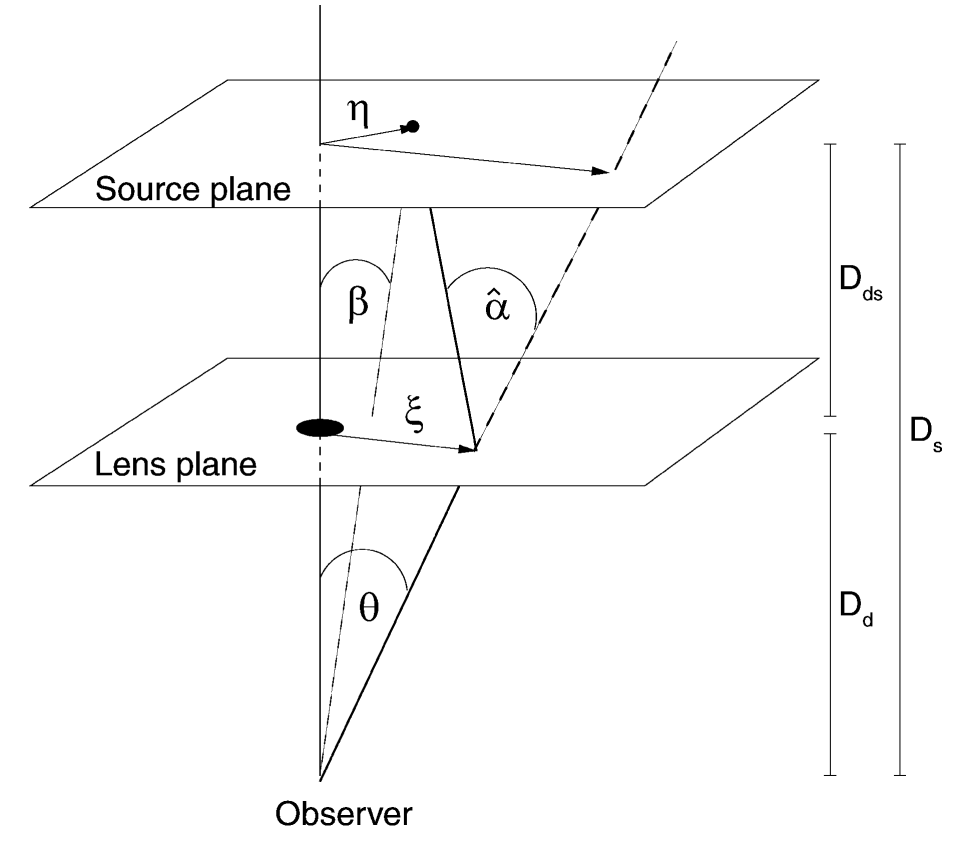

A illustration of how gravitational lensing works. Retrieved 23 March 2023, from http://astro.physics.uiowa.edu/~kaaret/2012f_29c235/L12_gravlens.pdf

## Implementation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class Lensing(object):
    '''
    This is a class that calculate the lensing due to gravitational effect.
    
    We will restrict our observing angle between +1 degree to -1 degree. That is, what we see 
    is a 2 degree by 2 degree square.
    
    '''
    def __init__(self,lense,source,Dd,Dds,N=100):
        
        '''
        initializing some parameters in the instance

        Parameters
        ----------
        
        lense: a 1001 x 1001 numpy matrix,
                storing the mass distribution of the lense
        
        source: a 1001 x 1001 numpy matrix,
                storing the brightness distribution of the source
        
        Dd : a float,
            the distance between the observer and the lense in meters
            
        Dds : a float,
            the distance between the lense and the source in meters
        
            step size of integration
        
        N: int,
            the length of one side of the picture
            
        '''
        
        self.lense = lense
        self.source = source
        self.Dd = Dd
        self.Dds = Dds
        self.Ds = Dd+Dds  # distance between the source and the observer
        self.G = 6.67e-11
        self.c = 3.0e8
        self.N=N
        #setup two scales in lense plane and source plane.
        

        self.lense_scale = 2/self.N
        self.source_scale = self.lense_scale*self.Dd/self.Ds

        
    def calculate_bending_angle(self):
            
        '''
        a convenient function calculating the bending angles
        
        Return
        ----------
        bending angles in vector form stored in a 1001x1001 numpy matrix
        
        '''
        bending_angle = np.zeros((self.N+1,self.N+1,2))
        const = 4*self.G/(self.c**2)/self.Dd/self.lense_scale
    
        for i in range(self.N+1):
            for j in range(self.N+1):
                
                lense = np.copy(self.lense)
                rows, cols = np.indices((self.N+1, self.N+1)) # construct a matrix where each element is a vector
                                                                 #the value of the vector is the index of the element
               
                lprime = np.stack((rows, cols), axis=-1)
                l = np.array([i,j])
                
                vec = l-lprime
                d = np.sum(vec**2, axis=2)
                d[d==0] = 1.0e5 # set the 0 to large value to avoid dividing by 0
                distance_vec = np.nan_to_num(vec/d[..., np.newaxis], nan=0)
                d_alpha = (distance_vec) * lense [..., np.newaxis] 
              
                bending_angle[i,j]=np.sum(d_alpha, axis=(0, 1))
                
        return bending_angle * const
    
    def get_brightness(self):
        '''
        a convenient function to find the lensed picture we see
        
        Return
        ----------
        brightness we see in a 1001x1001 numpy matrix (2D array)
        
        '''
        
        final_diagram = np.zeros((self.N+1,self.N+1))
        bendings = self.calculate_bending_angle()
        
        for i in range(int(-self.N/2),int(self.N/2+1)):
            for j in range(int(-self.N/2),int(self.N/2+1)):
                        
                theta = np.array([i,j])*self.lense_scale
                alpha = bendings[int(i+self.N/2),int(j+self.N/2)]*self.Dds/self.Ds
                beta = (theta-alpha)//self.source_scale

                        
                if beta[0]<=self.N/2 and beta[0] >= -self.N/2 and beta[1] <=self.N/2 and beta[1] >= -self.N/2:
                    final_diagram[int(i+self.N/2),int(j+self.N/2)] = self.source[int(beta[0]+self.N/2),int(beta[1]+self.N/2)]
        return final_diagram
        
    def get_initial_diagram(self):
        '''
        A convenient function calculating the unlensed picture
        
        Return
        ----------
        brightness we see without the lense in a 1001x1001 numpy matrix (2D array)
        '''
        initial_diagram = np.zeros((self.N+1,self.N+1))

        for i in range(int(-self.N/2),int(self.N/2+1)):
            for j in range(int(-self.N/2),int(self.N/2+1)):  
                
                vec = (np.array([i,j])-np.array([0.,0.]))*self.lense_scale//self.source_scale
                
                if vec[0]<=self.N/2 and vec[0] >= -self.N/2 and vec[1] <=self.N/2 and vec[1] >= -self.N/2:
                    initial_diagram[int(i+self.N/2),int(j+self.N/2)] = self.source[int(vec[0]+self.N/2),int(vec[1]+self.N/2)]

        return initial_diagram
    
    def display(self):
        '''
        A convenient function that wrap up everything. To show the diagram with the lense and without the lense.
        '''
        fig, ax = plt.subplots(1, 2)
        final_diagram = self.get_brightness()
        initial_diagram = self.get_initial_diagram()
        
        ax[0].imshow(initial_diagram,cmap='gray' )
        ax[1].imshow(final_diagram,cmap='gray')
        
        
        ax[0].set_title("unlensed")
        ax[1].set_title('lensed')
        plt.show()
    
    def mass(self):
        '''
        A convenient function that display the mass distribution on the lense plane
        '''
        
        plt.imshow(self.lense)
        plt.colorbar()
        plt.title("mass distribution")

## Testing cases

For testing purpose, we are going to produce the lensed version of the following image named "Stephan’s Quintet" taken by the James Webb Space Telescope. Note that in the tests, we are going compress the picture into a lower resolution and feed it into our code, so it may not look as nice as the original version.

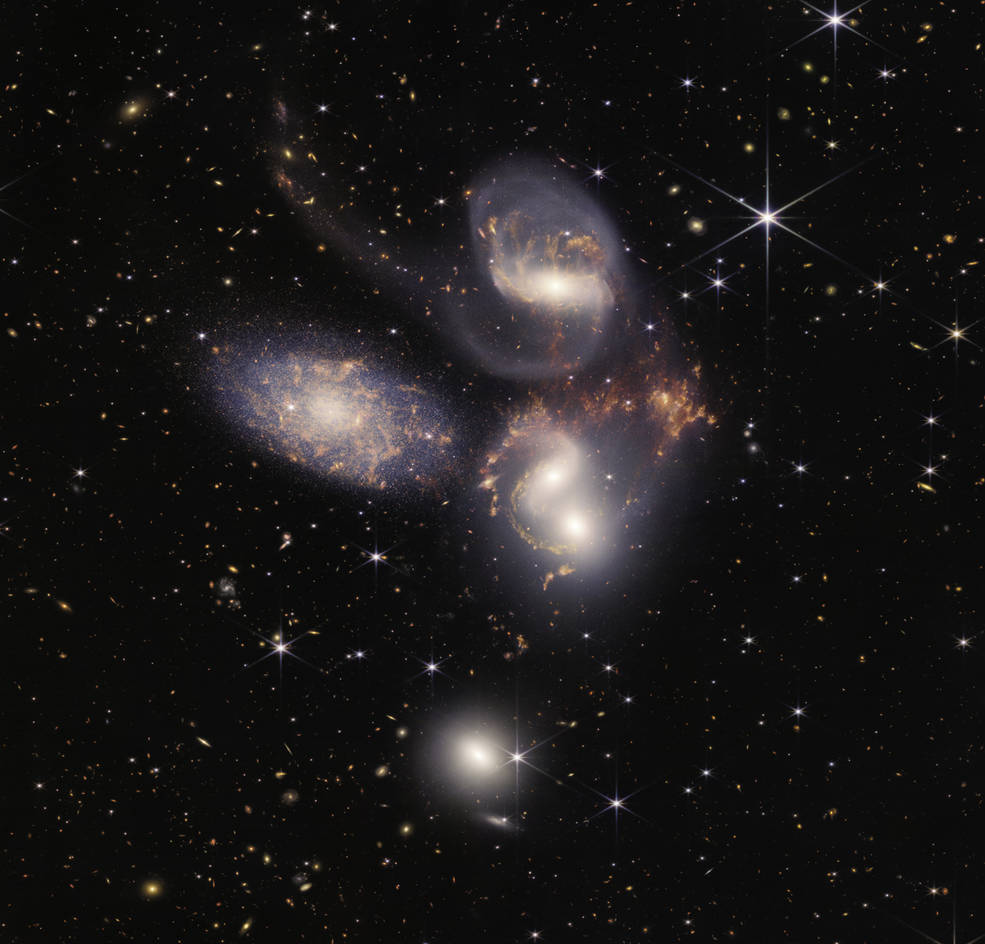

Stephan’s Quintet. Retrieved 18 April 2023, from https://www.nasa.gov/webbfirstimages

### Test 1: Point mass lens
In the first test, the lens plane consists of a single point mass in the center. We will calculate the bending angle and compare it with the following analytical formula (Dodelson, 2017):
$$ |\alpha| = \frac{4 G M}{|\theta| c^2}\frac{D_{ls}}{D_l D_s} $$

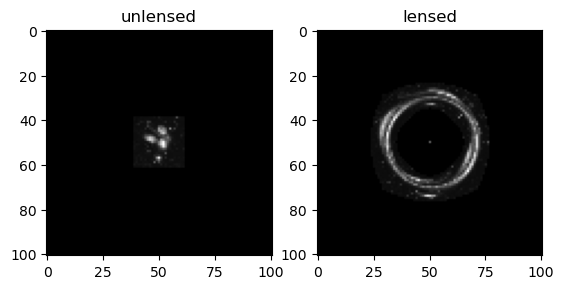

In [5]:
light_year = 9.46e15

# Test 1: point mass 
# We produce the lensed image first
N = 100
lense1 = np.zeros((N + 1, N + 1))
m1 = 2.0e44 # point mass

lense1[N // 2, N // 2] = m1 # place the point mass in the center of the lens

Dd = 300 * light_year # distances
Dds = 1000 * light_year

img = Image.open('main_image_galaxies_stephans_quintet_sq_nircam_miri_final-1280.jpg')

img = img.convert('L')

img = img.resize((N + 1, N + 1))
arr = np.array(img) / 255 # load and compress testing image

test1 = Lensing(lense1, arr, Dd, Dds, N)
test1.display()

As we can see, the image is distorted into a ring. This is called the Einstein ring and is expected when the mass distribution of the lens is circular symmetric, which is of course true for this point mass case. We will discuss more about Einstein ring in the Exploration section.

We then check if the bending angles are indeed identical as given by the above formula.

In [6]:
# We check if the bending angle is indeed given by the formula
bend_angle_data = test1.calculate_bending_angle() # the list of bending angles
indicator = True # indicator for test success
analytic_alpha_list = np.zeros((test1.N, test1.N))
calculated_alpha_list = np.zeros((test1.N, test1.N)) # We store the calculation results (from the program and the formula) in lists
for i in range(int(-test1.N / 2), int(test1.N / 2 + 1)):
    for j in range(int(-test1.N / 2), int(test1.N / 2 + 1)):
        theta = np.array([i, j]) * test1.lense_scale
        theta_norm = np.sqrt(np.sum(theta ** 2))

        calculated_alpha = bend_angle_data[int(i + test1.N / 2), int(j + test1.N / 2)] * test1.Dds / test1.Ds
        calculated_alpha_norm = np.sqrt(np.sum(calculated_alpha ** 2))
        calculated_alpha_list[i, j] = calculated_alpha_norm
        # We compute alpha from the list of bending angles in the same way as the function get_brightness

        # Compute alpha using the formula
        if theta_norm < 1e-10:
            analytic_alpha_norm = 0  # In the top-left corner where i, j = 0, this analytic formula is dividing by zero. We set alpha to be zero there
        else:
            analytic_alpha_norm = 4 * test1.G * m1 / ((test1.c ** 2) * theta_norm) * test1.Dds / (test1.Ds * test1.Dd)
        analytic_alpha_list[i, j] = analytic_alpha_norm

        if np.abs(analytic_alpha_norm - calculated_alpha_norm) < 1e-10:
            indicator = indicator and True
        else:
            indicator = indicator and False
        # Check if the alphas are equal within the tolerance of 1e-10
if indicator:
    print("Test passed!")
else:
    print("Test failed")
print("The greatest discrepancy from the value calculated by the analytical formula is " +
      str((np.abs(analytic_alpha_list - calculated_alpha_list)).max()))

Test passed!
The greatest discrepancy from the value calculated by the analytical formula is 1.3322676295501878e-15


### Test 2：Uniform mass density sheet 
For uniform mass density sheet, the lensed picture should only be magnified (Dodelson, 2017). There should not be distortion in the final picture.

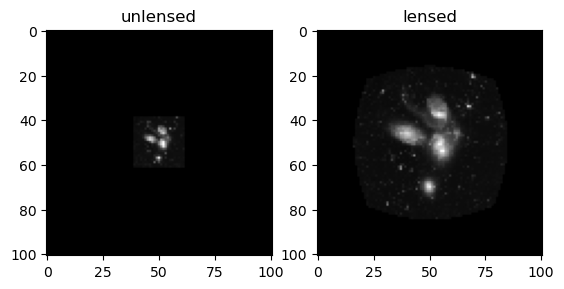

In [7]:
# Test 2: uniform mass density sheet
N = 100
rho = 1e41 # uniform density 
lense2 = np.full((N + 1, N + 1), rho) #construct the lens
test2 = Lensing(lense2, arr, Dd, Dds, N)
test2.display()

As we can see, for this uniform mass density sheet case, the image is only magnified without distortion. This is as expected.

#### Remark
In the above testing cases, we have tried many values for the parameters (the mass of the point mass, the mass density, etc) when writing the testing code. We found out the currently used values could produce lensed images with the best qualities. 

## Comparison with the other version of the code
We can also construct the code in the most straightforward way (This is actually the first version of our code when writing the interim report). That is, we can trace the light from the source to the observer. Note this that in this case, the light ray will not hit the observer for sure. Therefore, we will only check the bending angle value and compare it with the formula to see it is correct even we work in forward direction.

In [8]:
class Light(object):
    
    '''
    A class that handle with the trajectory of one light ray in gravitational lensing problem

    '''
    def __init__(self,f,f_range,beta,D_lo,D_sl):
        '''
        

        Parameters
        ----------
        f : function f(r,theta) of mass distribution of the gravitational lense
        
        f_range : a float describing the furthest distance between the origin and the furthest mass.
    
        p_s: a 1x2 narray describing the position of the source of the light
        
        D_lo: a float; distance between the lense and observer
        
        D_sl: a float; distance between the source and lense
        Returns
        -------
        None.

        '''
        self.f = f
        self.f_range = f_range
        self.beta = beta
        self.D_lo = D_lo
        self.D_sl = D_sl
        self.theta = None
        self.alpha = None
        
        self.G = 6.67e-11
        self.c = 3.0e8
        
    def convert_polar(self,car_position):
        '''
        convenient function to convert Cartesian coordinate to Polar coordinate

        Parameters
        ----------
        car_position : np array
            x y  coordinate in Cartesian coordinate
       
        Returns
        -------
        1x2 numpy array, coordinate in polar coordinate [r,theta]
        
        '''
        x = car_position[0]
        y = car_position[1]
        
        r = np.sqrt(x**2+y**2)
        theta = np.arctan2(y, x)
        
        return np.array([r,theta])
        
        
    def bending_angle_alphahat(self,h=100.,pointmass = 1):
        '''
        
        convenient function to calculate the bending angle beta 
        Parameters
        ----------
        h : float
            step size of integration
        pointmass : boolean
            if the mass distribution is a point mass, enter 1
            else enter 0
        Returns
        -------
        1x2 numpy array, bending angle beta

        '''
        if pointmass:
            h = 1
        
        xs = np.arange(-self.f_range,self.f_range+h,h)
        ys = np.arange(-self.f_range,self.f_range+h,h)
        p0 = self.beta*(self.D_lo+self.D_sl)
        #print(p0)
        integral = np.zeros(2) 
        for x in xs:
            for y in ys:
                
                p = np.array([x,y])
 
                m = self.f(self.convert_polar(p)) #getting the mass at p
                integral+= m* (p0-p)/np.sum((p0-p)**2)*h**2   #if this is not point mass, need to include h**2
                
        return  4*self.G/(self.c**2) * integral
    
    def image(self,pointmass = 1):
        '''
        
        convenient function to calculate the viewing angle theta 
        Parameters
        ----------
        pointmass : boolean
            if the mass distribution is a point mass, enter 1
            else enter 0
        Returns
        -------
        1x2 numpy array, viewing angle theta
        
        '''
        theta = self.beta + self.D_sl/(self.D_sl+self.D_lo)*self.bending_angle_alphahat(pointmass = pointmass)
        p_image = theta * (self.D_sl+self.D_lo)
        
        self.theta = theta
        self.alpha = self.D_sl/(self.D_sl+self.D_lo)*self.bending_angle_alphahat(pointmass = pointmass)
        
        return theta
    

### Test 1: point mass 
We still have a point mass on the lens plane. We randomly choose 10 initial angles from the source and trace the point it lends on the lens plane. Then, we calculate the bending angles for them and compare the bending angles with the formula.

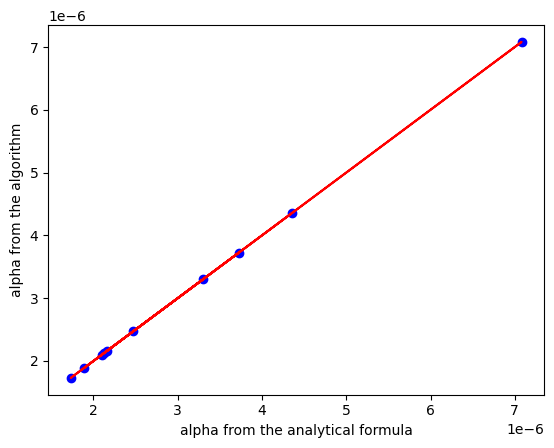

In [9]:
# test 1
m = 2.0e38 # point mass
def f(p):
    R = 3000.
    r = p[0]
    theta = p[1]
    
    if r==0:
        return m
    else:
        return 0 #define the source
light_year = 9.46e15
d_sl = 30*light_year
d_lo = 30*light_year # relevant distances

# some parameters
G = 6.67e-11
c = 3.0e8
a_algorithm = []
a_formula=[]

for beta in (np.random.rand(10,2)-0.5): # generating 10 randon angles and calculate the bending angles.
    a = Light(f,30,beta,d_lo,d_sl)
    a.image()
    a_algorithm.append(np.sqrt(np.sum(a.bending_angle_alphahat()**2)))
   
    #print('alphahat from algorithm',np.sqrt(np.sum(a.bending_angle_alphahat()**2)))
    theta=a.theta
    a_formula.append(4*G*m*d_sl/(np.sqrt(np.sum(theta**2))*c**2*d_lo*(d_lo+d_sl)))
    #print('alphahat from formula',4*G*m*d_sl/(np.sqrt(np.sum(theta**2))*c**2*d_lo*(d_lo+d_sl)))
plt.plot(a_formula,a_algorithm,'bo')
plt.plot(a_formula,a_algorithm,'r')
plt.xlabel('alpha from the analytical formula')
plt.ylabel('alpha from the algorithm')
plt.show()

We see that the values line on y=x. That means all values agree. 

### Test 2: Uniform mass density sheet

#### Note: 
We do not recommend execute this code in Jupyterhub. Due to the serious efficiency issue of this version of the code, it would take an extremely long time to execute this test. The plots for the testing results were produced on our own laptops using local IDE. 

For the second test, we test this algorithm with a uniform sheet of mass. The first figure shows the viewing angle $\overrightarrow{\beta}$ without the lens. The second figure shows the viewing angle $\overrightarrow{\theta}$ after being lensed by the mass sheet.

In [ ]:
# test 2
m = 2.0e39
def f(p):
    R = 3000
    r = p[0]
    if r <3000:
        return m/(4*np.pi*R**2)
    else:
        return 0 # uniform mass density

# some parameters
f_range = 3000
light_year = 9.46e15
d_sl = 300*light_year
d_lo = 300*light_year

# source points
source = []
for i in range(10):
    a=[(i+1)*0.1*np.pi/180,(i+1)*0.1*np.pi/180]
    source.append(a)
s =np.array(source)

for i in range(10):
    b = s[i]
    plt.plot(b[0],b[1],'ro')
plt.xlabel('Horizontal component of beta')
plt.ylabel('Vertical component of beta')
plt.show()
    
for i in range(10):
    b = s[i]
    light_b = Light(f,f_range,b,d_lo,d_sl)
    c= light_b.image()
    plt.plot(c[0],c[1],'ro')
plt.xlabel('Horizontal component of theta')
plt.ylabel('Vertical component of theta')
plt.show()

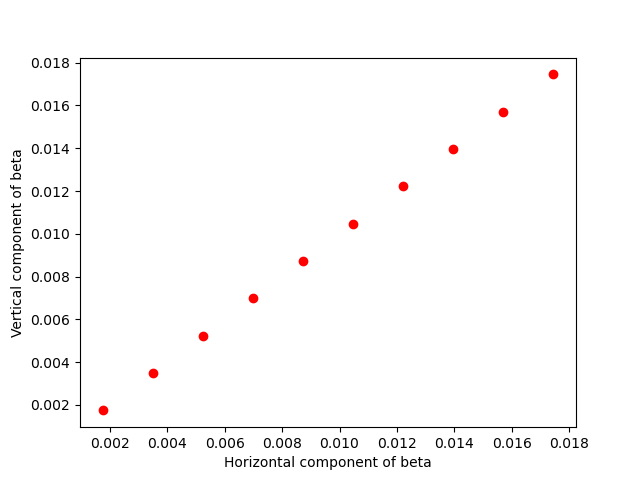
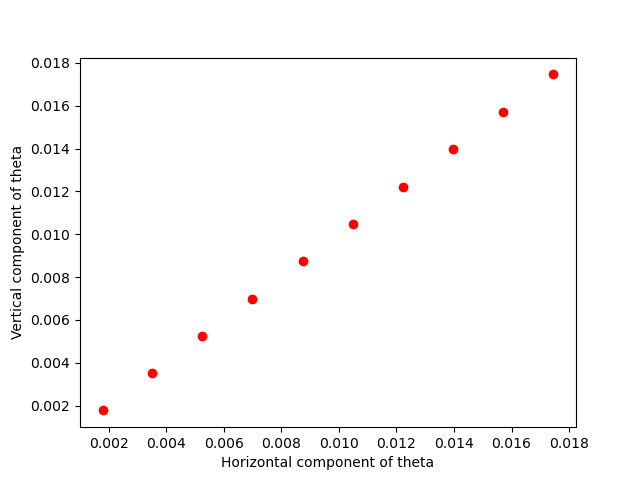

We see that the sapcing between adjacent points (which are the positions of the image in the view with or without lens) are scaled by approximately the same factor after being lensed. This means the image produced by a uniform mass density sheet is only magnified without distortion. (Personally I think the result of this test is not visually clear enough. But this is indeed the same test we conducted when writing the interim report, so we would keep it here.)

### Comparison with the first (core) version of the code

The second version of the code has a significant efficiency issue. To compute the bending angle for a few points (like the tests we conducted above), it would take a few minutes to execute. This is because in the second version, we are tracing the light from the source to the observer. Not all light rays will hit the observer ultimately. So, it wastes a lot of time and source on computing parameters for these "useless" light rays. This is also the reason why we do not include any lensed image here like what we did for the first version of the code. It would take an unreasonable amount of time to produce such pictures if using the second version of the code. In contrast, in the first version of the code, we are tracing the light in the reverse direction, which is from the observer to the source to find out which pixel on the source plane that the observer actually see and then construct all those pixel into a diagram. This ensures all light rays we are tracing are "useful" for producing the lensed image. This resolves the efficiency issue occurred in the second version of the code and as we can see, we successfully produced the lensed image for a large picture. 

The second version of the code was our original code when writing the interim report. Here we express our appreciation to professor Mike Hudson, who made us realized the issue in our original code and enlightened us on how to develop the new version of the code (this is the first version of the code showed in this report).

Although both versions of the code are tested to be correct in terms of physical predictions, since the first version is much more efficient and allows us to produce lensed images (which is essential for our explorations below), we choose the first version of the code to be our core code. We will use it in the following sections. 

## Explorations

### Einstein Rings, giant arcs and Einstein cross

#### Case One: Circular Symmetric Lens Mass Distribution: Einstein Ring
Background Information:
Einstein Rings is a special case for gravitational lensing which happened when the source, lens and observer align perfectly with each other. To be specific, there are two requirements (Dodelson, 2017):

1). The mass distribution of the lens needs to be approximately axially symmetric, as seen from the observer.

2). And the source, lens and observer align along a straight line of sight. (In our simulation, we align source, lens and observer all along the z-axis.)

Expected Effect:
The resulted image will be a ring.

Then, we adjust slightly the position of the source(ex. A little bit Off the center) and while keeping lens the same to see what happens.

Note that in this exploration, we will use source distributions that are humanly constructed, instead of real pictures like what we did for the testing cases. This is because such sources are more flexible to adjust and would enable us to observe the effect of lensing more clearly

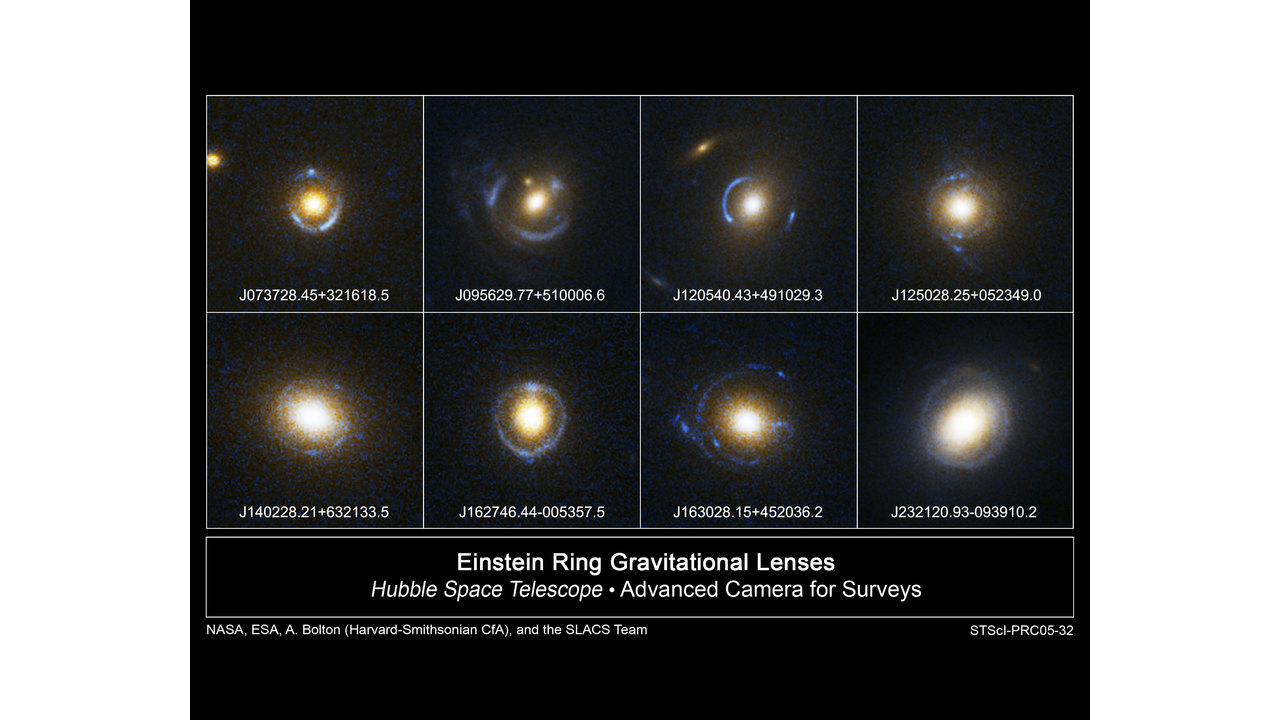

Some images of Einstein rings taken by the Hubble Space Telescope. Retrieved 18 April 2023, from https://hubblesite.org/contents/media/images/2005/32/1788-Image.html

In the first case, we have perfectly aligned source, circular distributed lens and observer. 

In [10]:
# Some parameters for testing
N = 100
light_year = 9.46e15
Dd = 3e9*light_year
Dds = 3e9*light_year

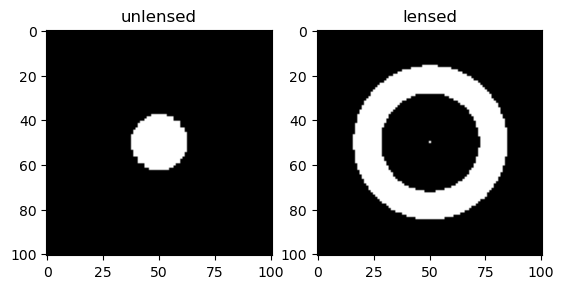

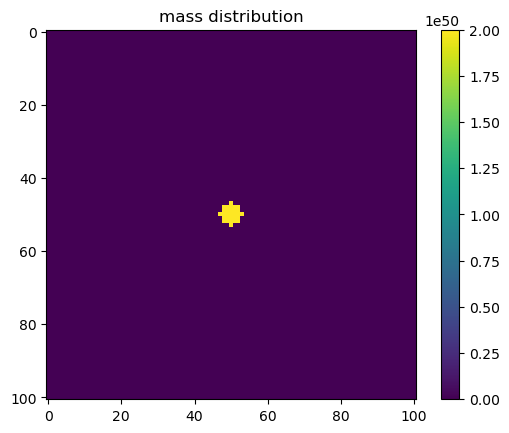

In [11]:
#Case 1-Einstein Ring:

lense1 = np.zeros((N+1,N+1))
source1 = np.zeros((N+1,N+1))
m1 = 2.0e50

#Lense Mass Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 < 10 :
            lense1[i, j] = m1

#Source Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 < (N/4)**2 :
            source1[i,j] = m1/(np.pi*(N/4)**2)
            
testE = Lensing(lense1, source1, Dd, Dds,N)
testE.display()
plt.figure()
testE.mass()

As we can see, after being lensed the image becomes a perfect Einstein ring. This is as expected. 

In the second case, we deviate the source from the center axis so that source, lens and observer are not perfectly aligned. 

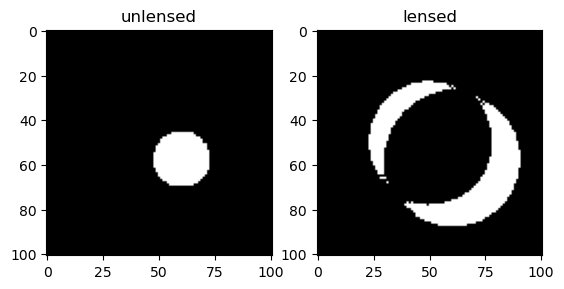

<Figure size 640x480 with 0 Axes>

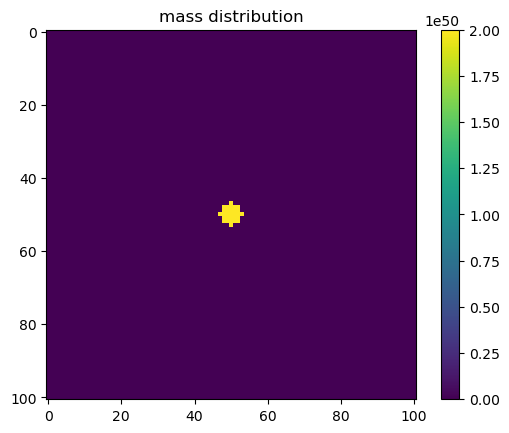

<Figure size 640x480 with 0 Axes>

In [12]:
#Case 2-Moving Source Distribution(Off the center)
source = np.zeros((N+1,N+1))

#Source Distribution(Centered at 70,65)
source2 = np.zeros((N+1,N+1))
for i in range(N+1):
    for j in range(N+1):
        if (i-65)**2+(j-70)**2 < (N/4)**2 :
            source2[i,j] = m1/(np.pi*(N/4)**2)

testC2 = Lensing(lense1, source2, Dd, Dds,N)
testC2.display()
testC2.mass()
plt.figure()

As we can see, the perfect ring breaks up and is weighted towards the direction that the source is deviated. 

If we move the source further away from the center, the lensed image will become the following. 

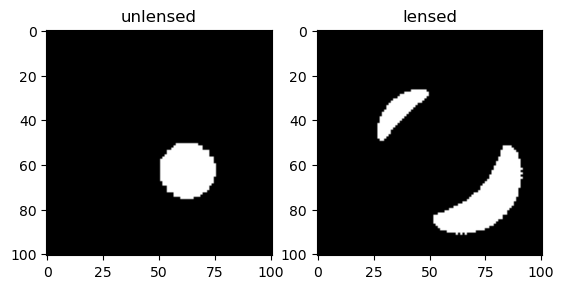

<Figure size 640x480 with 0 Axes>

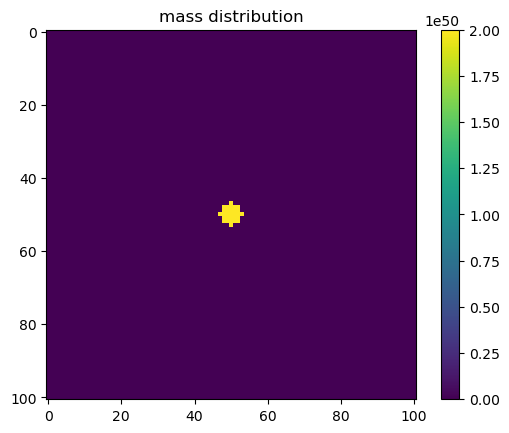

<Figure size 640x480 with 0 Axes>

In [13]:
#Moving Source Distribution(further off the center)
source21 = np.zeros((N+1,N+1))

#Source Distribution(Centered at 75,75)
source21 = np.zeros((N+1,N+1))
for i in range(N+1):
    for j in range(N+1):
        if (i-75)**2+(j-75)**2 < (N/4)**2 :            #Adjust the source more off the center
            source21[i,j] = m1/(np.pi*(N/4)**2)

testC21 = Lensing(lense1, source21, Dd, Dds,N)
testC21.display()
testC21.mass()
plt.figure()

As we can see, the image becomes two arcs that are more separated from each other. 

#### Case Two: Elliptical Lens Mass Distribution: Einstein Cross and Giant Arc

In real observations, it is very real that the source, lens and observer align along a straight line of sightand the mass distribution of the lensing object is axially symmetric as seen by the observer. It is more often that the lensing object is elliptical as seen by the observer. Therefore, we are trying to explore what would happen if the lensing object is elliptically distributed. 

In the first case, we consider the case when the source, lens and observer are aligned but the lens is elliptical. The ellipse does not have very large eccentricity. 

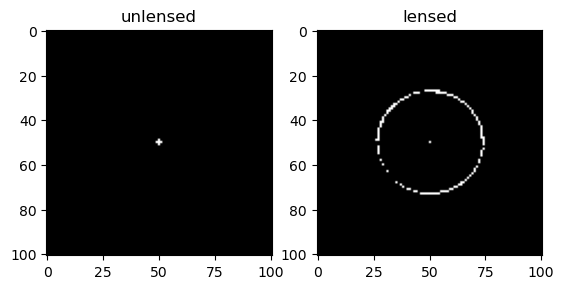

<Figure size 640x480 with 0 Axes>

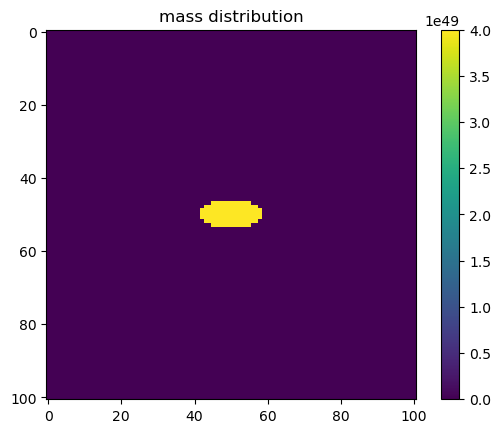

<Figure size 640x480 with 0 Axes>

In [26]:
#Case 3-Elliptical Lens Mass Distribution produces Einstein ring
source3 = np.zeros((N+1,N+1))
lense3 = np.zeros((N+1,N+1))
mt1= int(2.0e49*2)
#Source Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 < 5 :
            source3[i,j] = m1/(np.pi*(N/4)**2)
            
#Lens Mass Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N*1/2)**2/1.5+(j-N*1/2)**2/8 < 10 :
            lense3[i, j] = mt1

testC3 = Lensing(lense3, source3, Dd, Dds,N)
testC3.display()
testC3.mass()
plt.figure()

As we can see, the lensed image for this case is almost identical as the axially symmetric case. The lensed image forms an Einstein ring.

We then see what will happen when the ellipse in the last case has very large eccentricity: 

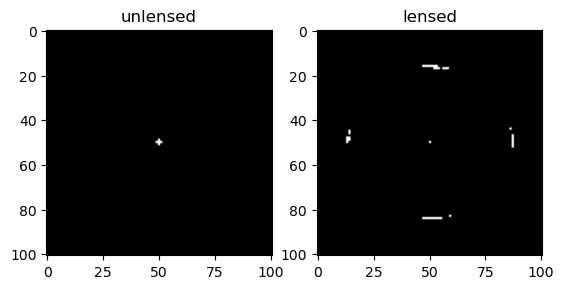

<Figure size 640x480 with 0 Axes>

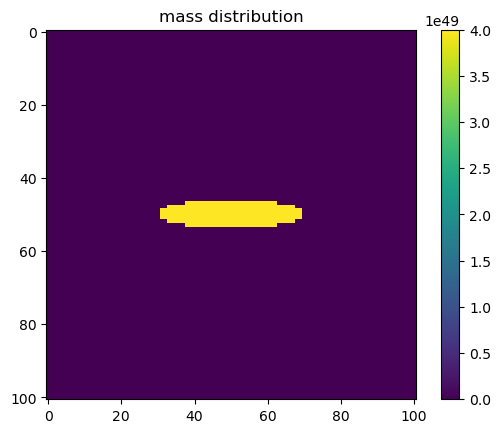

<Figure size 640x480 with 0 Axes>

In [27]:
#Case 4-Elliptical Lens Mass Distribution produces Einstein Cross
source4 = np.zeros((N+1,N+1))
lense4 = np.zeros((N+1,N+1))

#Source Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 < 5 :
            source4[i,j] = m1/(np.pi*(N/4)**2)
            
#Lens Mass Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N*1/2)**2/1.5+(j-N*1/2)**2/40 < 10 :
            lense4[i, j] = mt1

testC4 = Lensing(lense4, source4, Dd, Dds,N)
testC4.display()
testC4.mass()
plt.figure()

As we can see, the lensed image of the source is splitted into four points that look like a cross when opposite points are connected. This is called the Einstein Cross and is actually observed in astronomical observations: 
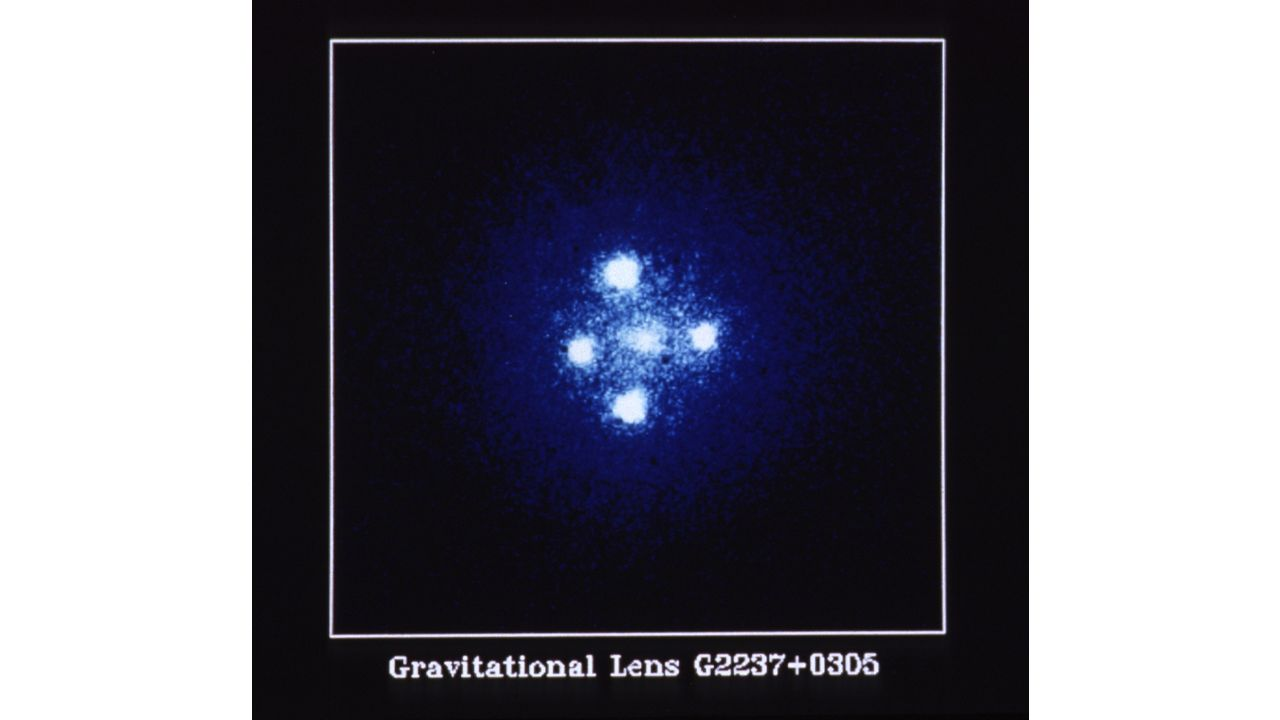

An Einstein Cross observed by the Hubble Space Telescope. Retrieved 18 April 2023, from https://hubblesite.org/contents/media/images/1990/20/22-Image.html

Here is another set of parameters we discovered that will produce an Einstein Cross

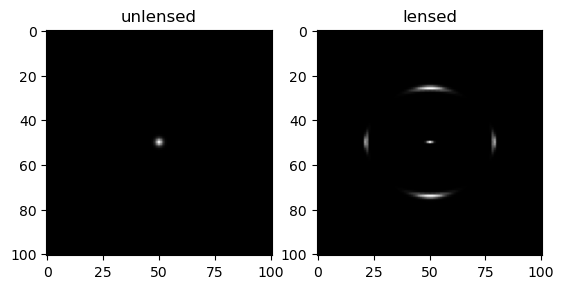

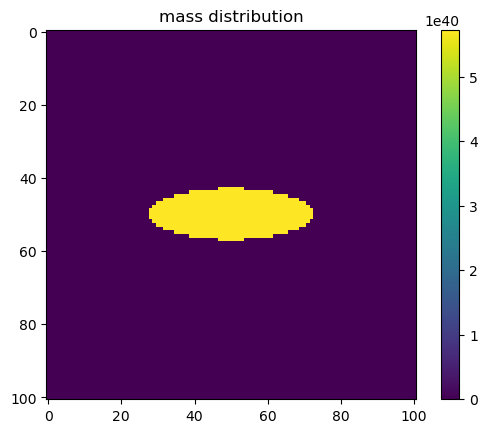

In [28]:
# Another set of parameters that produce Einstein cross
source42 = np.zeros((N+1,N+1))
lense42 = np.zeros((N+1,N+1))

# some parameters
m = int(2e44)
Dd = 30*light_year
Dds = 300*light_year

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 <= (N/1.7)**2:
            source42[i,j] = np.exp(-(i-N/2)**2/300-((j-N/2)**2)/300)

#Lens Mass Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2/10 < (N/2):
            lense42[i,j] = m/(np.pi*(N/3)**2)     

lense = lense42
            
testC42 = Lensing(lense42,source42,Dd,Dds,N)
testC42.display()
testC42.mass()

As we can see, the lens is still elliptically distributed, with a large eccentricity. 

We then consider the case when the source and lens are not aligned, and the lens is elliptically distributed: 

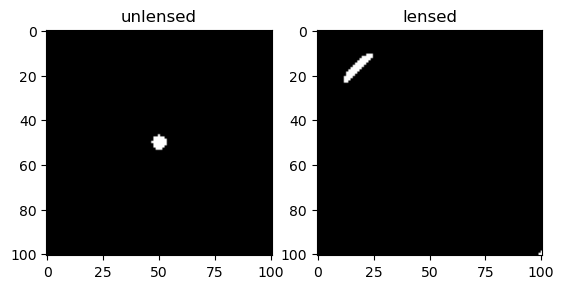

<Figure size 640x480 with 0 Axes>

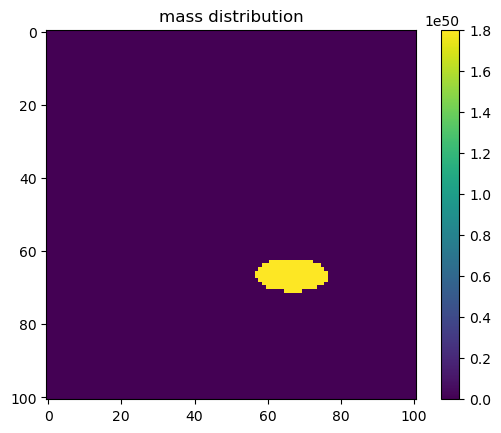

<Figure size 640x480 with 0 Axes>

In [29]:
#Case 5-Elliptical Lens Mass Distribution produces Giant arc
source5 = np.zeros((N+1,N+1))
lense5 = np.zeros((N+1,N+1))

# some parameters
Dd = 3e9*light_year
Dds = 3e9*light_year
mt2 = int(9e49*2)

#Source Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 < 40 :
            source5[i,j] = m1/(np.pi*(N/4)**2)
            
#Lens Mass Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N*2/3)**2/2+(j-N*2/3)**2/10 < 10 :
            lense5[i, j] = mt2

testC5 = Lensing(lense5, source5, Dd, Dds,N)
testC5.display()
testC5.mass()
plt.figure()

As we can see, only one arc is left after the lensing. This is called the giant arc, which has been observed in astronomical observations as well: 
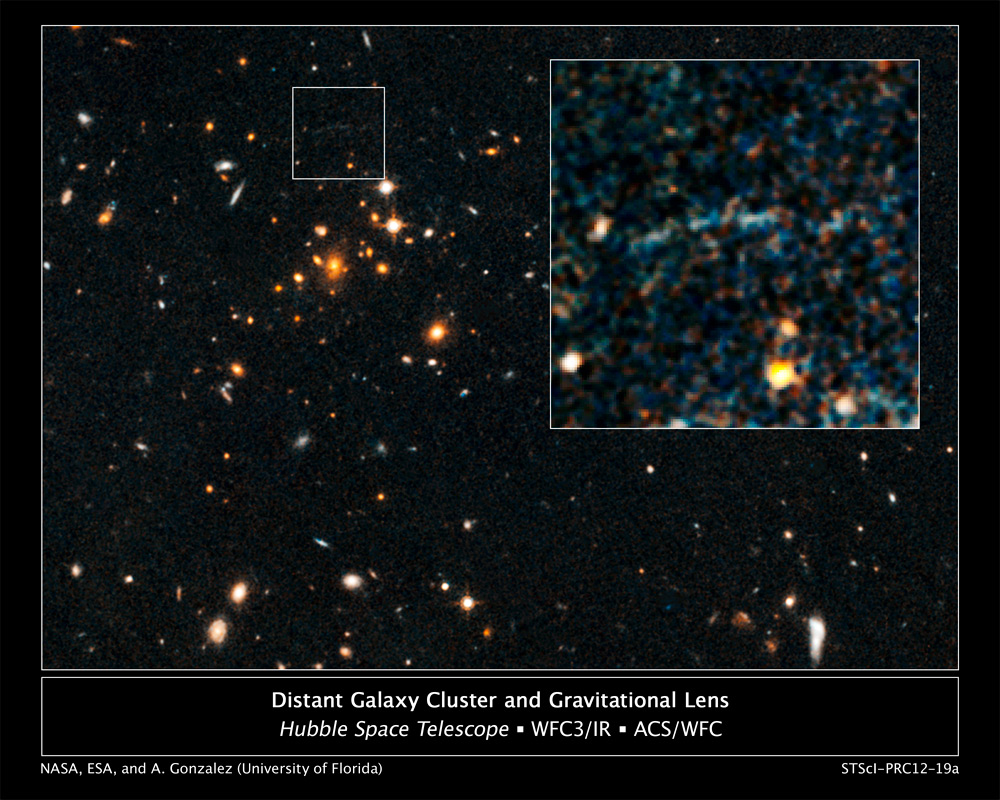

A giant arc observed by the Hubble Space Telescope. Retrieved 18 April 2023, from https://www.nasa.gov/mission_pages/hubble/science/gravitation-arc.html

### Caustics in Gravitational Lensing

According to the source (Ellis, 2010), for a elliptical-shaped lens, the relative positions of the source and the lens could result in different configurations in the lensed image. This is illustrated in the following image: 

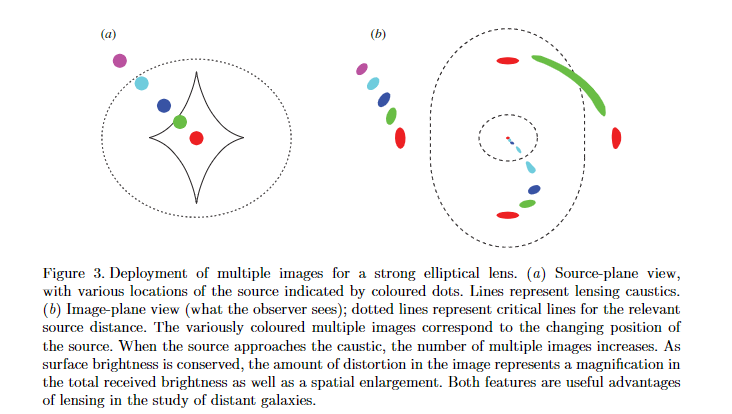

An illustration of caustics in gravitational lensing. Retrieved 21 April 2023, from https://doi.org/10.1098/rsta.2009.0209. 

The elliptical and dimond-shaped curves are called caustics. As we can see, when the source is outside the elliptical-shaped caustics (the purple dot in the picture), only one image is produced. When the source moves diagonally towards the center of the elliptical lens, multiple image configurations could occur, including two images, three images, two images and an arc and Einstein cross. According to (Ellis, 2010), we can find analytical equations for both caustics when the mass distribution of the lens is perfectly elliptical, but it requires some quite complicated calculations that involve general relativity. Luckily, since now we possess our simulation code, we can simulate the procedure of source moving from the center of the elliptical lens outward diagonally by using our code. Here are some lensed images we produce:

In the first case, the source is perfectly aligned with the center of the elliptical lens, and an Einstein Cross is produced (which is identical as the red spot in the above illustration): 

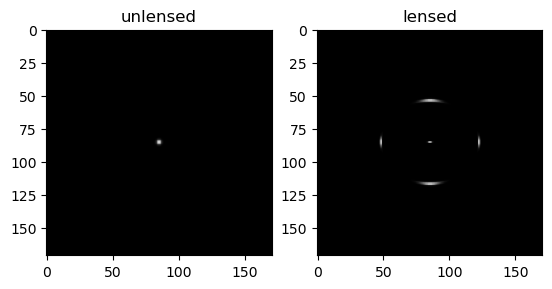

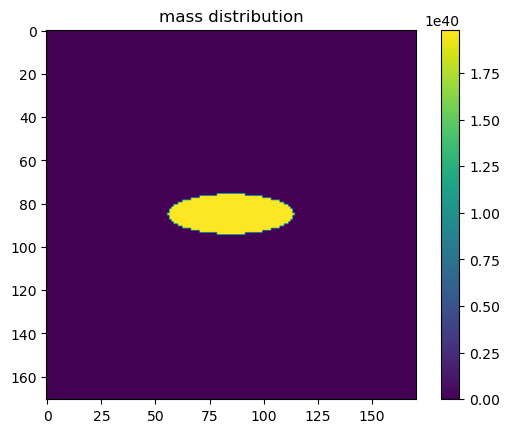

In [14]:
# perfect alignment produces Einstein cross
N=170
source61 = np.zeros((N+1,N+1))
lense61 = np.zeros((N+1,N+1))

# some parameters
m = int(2e44)
Dd = 30*light_year
Dds = 300*light_year

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2 <= (N/1.7)**2:
            source61[i,j] = np.exp(-(i-N/2)**2/300-((j-N/2)**2)/300)
            
#Lens Mass Distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2)**2+(j-N/2)**2/10 < (N/2):
            lense61[i,j] = m/(np.pi*(N/3)**2)     

testC61 = Lensing(lense61,source61,Dd,Dds,N)
testC61.display()
testC61.mass()

When the source moves diagonally away from the center by a small amount, two bright spots of the Einstein Cross will merge to form a giant arc:

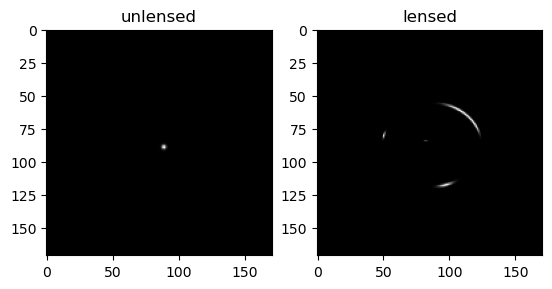

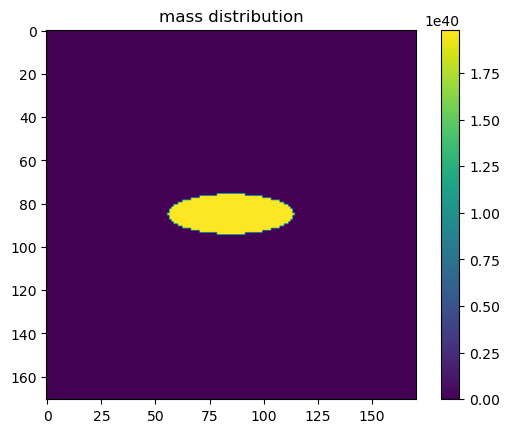

In [15]:
# Moving diagonally away from the center by a small amount will produce two bright spots and one giant arc

source62 = np.zeros((N+1,N+1))


# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-40)**2+(j-N/2-40)**2 <= (N/1.7)**2:
            source62[i,j] = np.exp(-(i-N/2-40)**2/300-((j-N/2-40)**2)/300)
                        
testC62 = Lensing(lense61,source62,Dd,Dds,N)
testC62.display()
testC62.mass()

We remark that this case is identical as the green spot in the illustration above.

When we move the source further away from the center, only two bright spots and a very faint arc will be left, plus a distorted image of the source in the center: 

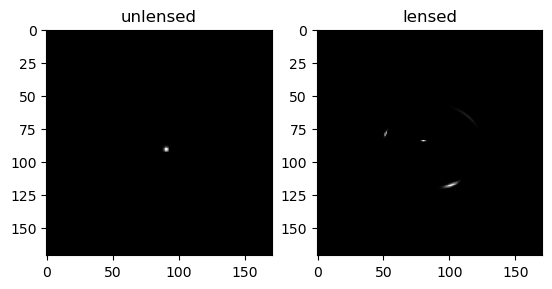

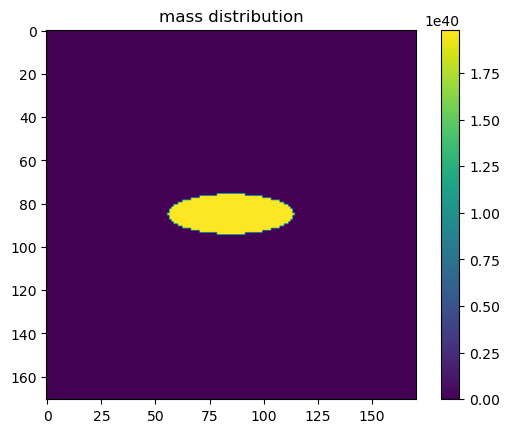

In [17]:
# Moving further away from the center, only two bright spots and a very faint arc are left

source63 = np.zeros((N+1,N+1))

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-60)**2+(j-N/2-60)**2 <= (N/1.7)**2:
            source63[i,j] = np.exp(-(i-N/2-60)**2/300-((j-N/2-60)**2)/300)
            
testC63 = Lensing(lense61,source63,Dd,Dds,N)
testC63.display()
testC63.mass()

We remark that this is similar as the dark blue spot in the above illustration.

When we move away by a further amount, the faint arc will disappear:

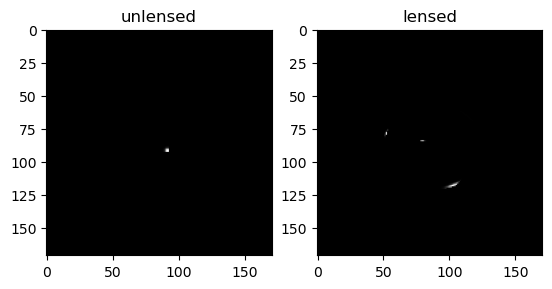

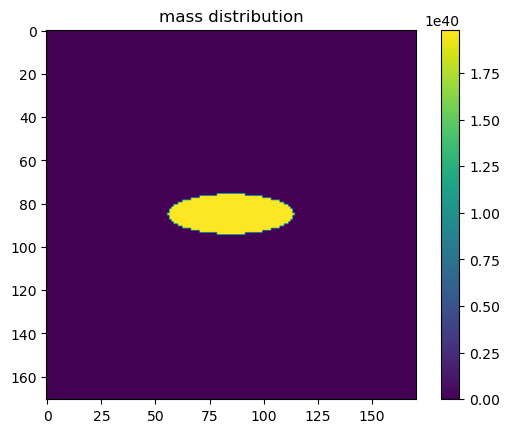

In [18]:
# Moving further away, the faint arc disappear
source64 = np.zeros((N+1,N+1))


# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-70)**2+(j-N/2-70)**2 <= (N/1.7)**2:
            source64[i,j] = np.exp(-(i-N/2-70)**2/300-((j-N/2-70)**2)/300)
                 
testC64 = Lensing(lense61,source64,Dd,Dds,N)
testC64.display()
testC64.mass()

This is similar as the dark blue or light blue spot in the above illustration.

Finally, if we move away from the center by a large amount, only one bright spot will be left, plus one very faint spot:

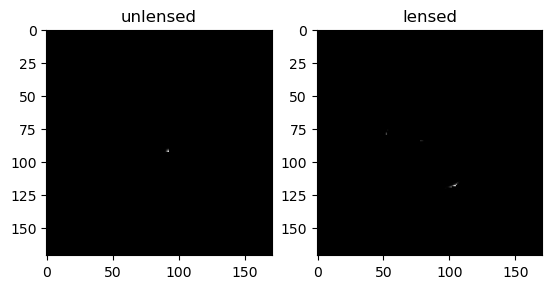

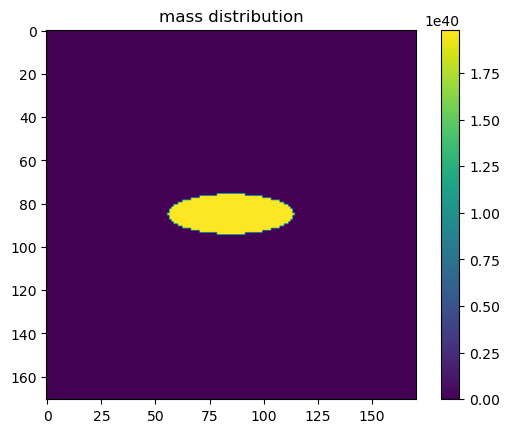

In [19]:
# Moving further enough, only one bright spot left

source65 = np.zeros((N+1,N+1))

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-84)**2+(j-N/2-84)**2 <= (N/1.7)**2:
            source65[i,j] = np.exp(-(i-N/2-84)**2/300-((j-N/2-84)**2)/300)
            
testC65 = Lensing(lense61,source65,Dd,Dds,N)
testC65.display()
testC65.mass()

This is similar as the purple or the light blue spot in the above illustration. 

Now we have basically verified the configurations of the lensed image in the illustration above. Just out of curious, let us explore what will happen if the source moves away from the center horizontally, instead of diagonally. This means the trajectory of the source would touch the vertice of the diamond-shaped coustics, instead of its edge. 

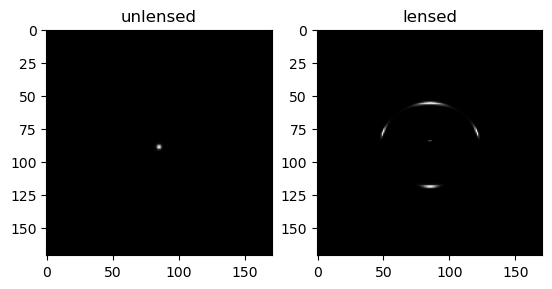

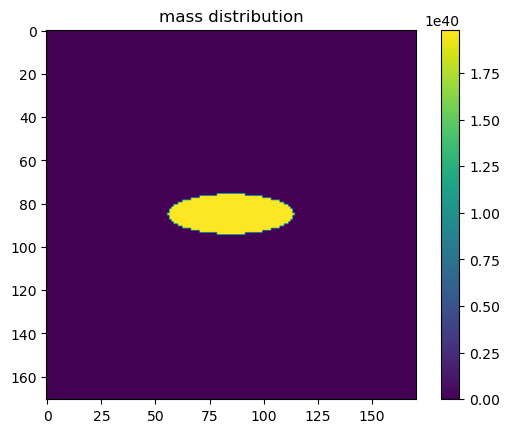

In [20]:
# Moving away from the center horizontally, by a small amount

source66 = np.zeros((N+1,N+1))

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-40)**2+(j-N/2)**2 <= (N/1.7)**2:
            source66[i,j] = np.exp(-(i-N/2-40)**2/300-((j-N/2)**2)/300)
            
testC66 = Lensing(lense61,source66,Dd,Dds,N)
testC66.display()
testC66.mass()

We see that three of the bright spots in the Einstein cross start to connect to form a giant arc. 

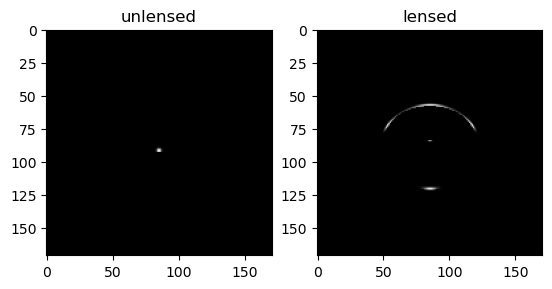

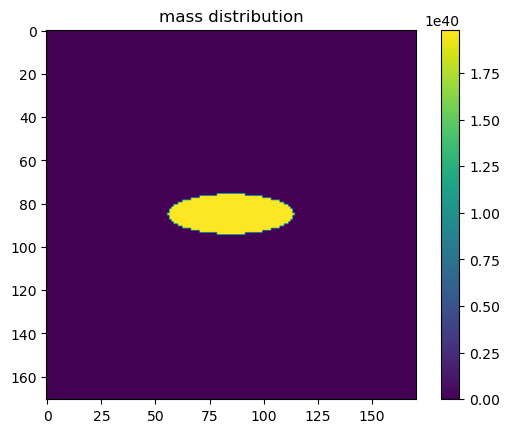

In [22]:
# Moving away from the center horizontally, by a further amount
source67 = np.zeros((N+1,N+1))

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-70)**2+(j-N/2)**2 <= (N/1.7)**2:
            source67[i,j] = np.exp(-(i-N/2-70)**2/300-((j-N/2)**2)/300)
            
testC67 = Lensing(lense61,source67,Dd,Dds,N)
testC67.display()
testC67.mass()

As we can see, when the source moves further away from the center, the giant arc becomes brighter. 

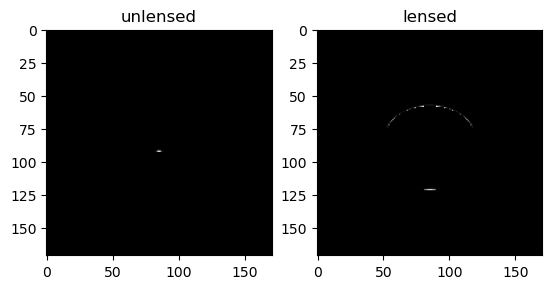

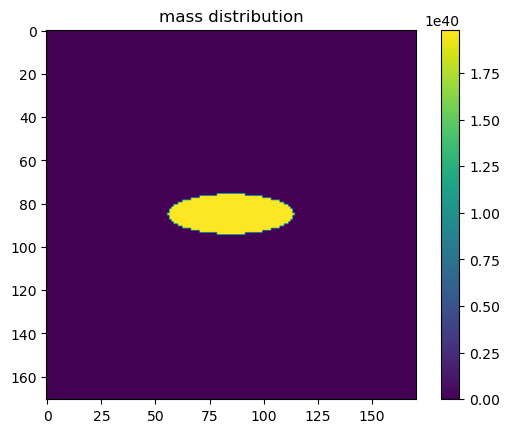

In [23]:
# Moving away from the center horizontally, by another further amount
source68 = np.zeros((N+1,N+1))

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-100)**2+(j-N/2)**2 <= (N/1.7)**2:
            source68[i,j] = np.exp(-(i-N/2-100)**2/300-((j-N/2)**2)/300)
            
            
testC68 = Lensing(lense61,source68,Dd,Dds,N)
testC68.display()
testC68.mass()

When the source moves away from the center by another further amount, the giant arc starts to become fainter. 

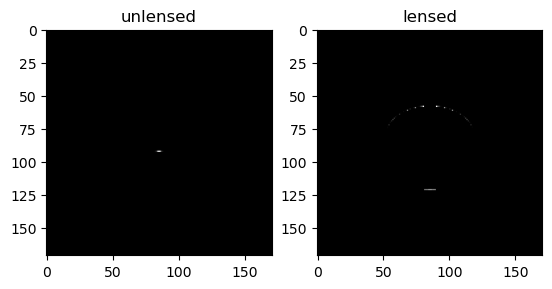

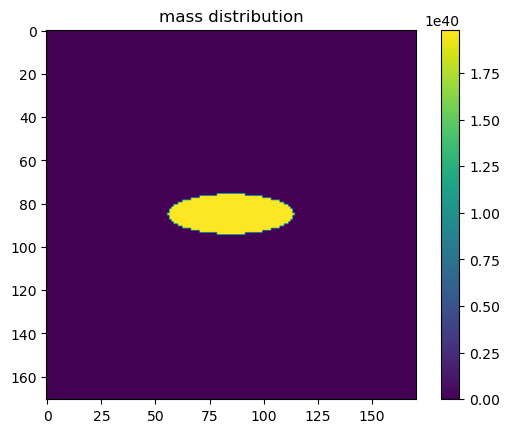

In [24]:
# Moving away from the center horizontally, by a large amount
source69 = np.zeros((N+1,N+1))

# Source distribution
for i in range(N+1):
    for j in range(N+1):
        if (i-N/2-130)**2+(j-N/2)**2 <= (N/1.7)**2:
            source69[i,j] = np.exp(-(i-N/2-130)**2/300-((j-N/2)**2)/300)
            
testC69 = Lensing(lense61,source69,Dd,Dds,N)
testC69.display()
testC69.mass()

Finally, as we can see, when the source moves away from the center by a large amount, the giant arc beecomes very faint and splits into several small bright spots

Overall, we conclude that the above exploration shows that when the source moves away from the center of the elliptical lens, the direction it moves does affect the configuration of the lensed image. In particular, when the source moves away diagonally (relative to the semi-major and semi-minor axes of the elliptical lens), two of the bright spots in the initial Einstein Cross will first connect to form a giant arc, and then this arc gradually fades away and only three, two or one bright spots will be left. When the source moves horizontally away from the center, three of the bright spots in the original Einstein Cross will connect to form a giant arc, and again this giant arc fades away gradually as the source moving outward but more bright spots will be left compared to the previous case. Deeper explorations of this difference may require some careful calculations that involve general relativity, which is out of the scope of this report. 

## Discussion and Conclusion

In this final project, we have developed an algorithm that simulates gravitational lensing numerically. The key thing we have learnt when developing this algorithm is that for optical simulations, tracing the light ray backwards can greatly improve the efficiency, since "useless" light rays are simply discarded. Afther verifying the validity of our algorithm, we used it for several exploration cases. We reproduced some of the phenomena that have been observed in astronomical observations, including the Einstein Ring, Einstein Cross and Giant Arc. We also examine the configurations of the lensed images when the source has different positions relative to the caustics. We also discovered the qualiative difference when the source moves away from the center of the elliptically distributed lens in different directions. Overall, this is an exciting and fruitful experience for all three of us. 

Although we have successfully resolved the efficiency issue in our original code and developed a very efficient new one using backward ray tracing and numpy array techniques, the new algorithm still works slowly for sources and lenses with very large sizes. This does not affect our explorations though, since relatively small sources and lenses are enough for us to demonstrate the key behaviours of the system. But in order to do more explorations and produce lensed images for pictures with larger sizes, we still need to improve the efficiency of our code. 

In my point of view, the numerical approach here cannot fully replace "paper-and-pencil" derivations using general relativity. For example, in order to discover the exact shape of the caustics, the lensing algorithm needs to be executed by a huge number of times before discovering the pattern. This may be simpler for a model with fewer parameters, but since we have many parameters here (quite a few distances, lens distributions, source distributions, etc), it is not straightforward. An analytical derivation may be more elegant and neat. 

Another theme we did not get a chance to explore is how gravitational lensing results from the Fermat principle. According to that principle, light would always take the path that takes the least amount of time. In principle, we can calculate the time delay for each path that the light can take, and select the one that takes the least amount of time to do ray tracing. We could have developed an alternative algorithm that produces the lensed picture by using that. However, after looking up many sources, we find out that almost all sources on this theme use different conventions, scales and units, and the formula for calculating time delay varies from author to author (which all have different factors and constant multiples on each term). This is a great barrier for implementing the time delay method as a concrete algorithm. Due to time limit, we did not get a chance to go over all of these sources and select a trustworthy one. However, I think this may be a good topic to explore after finishing this final project. 

Last but not least, we would like to express our appreciation towards professor Mike Hudson, who provided us with necessary help when we were stuck by the efficiency issue of our algorithm. Hope we can have more chances to collaborate in the future. 

## Reference 

Dodelson, S. (2017). Gravitational lensing. Cambridge University Press. 

Dunbar, B. (2022, June 8). First images from the James Webb Space Telescope. NASA. Retrieved April 18, 2023, from https://www.nasa.gov/webbfirstimages 

Dunbar, B. (n.d.). NASA's Hubble spots rare gravitational arc from distant, Hefty Galaxy Cluster. NASA. Retrieved April 18, 2023, from https://www.nasa.gov/mission_pages/hubble/science/gravitation-arc.html 

Ellis, R. S. (2010). Gravitational lensing: A unique probe of dark matter and Dark Energy. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 368(1914), 967–987. https://doi.org/10.1098/rsta.2009.0209 

A gallery of einstein rings - hubblesite.org. (n.d.). Retrieved April 18, 2023, from https://hubblesite.org/contents/media/images/2005/32/1788-Image.html 

The gravitational lens G2237 + 0305 - hubblesite.org. (n.d.). Retrieved April 18, 2023, from https://hubblesite.org/contents/media/images/1990/20/22-Image.html 

Kaaret, P. (n.d.). Gravitational Lensing. Philip Kaaret's Web Page. Retrieved March 23, 2023, from http://astro.physics.uiowa.edu/~kaaret/2012f_29c235/L12_gravlens.pdf 
